<a href="https://colab.research.google.com/github/archanaqre/Open_Information_Extraction/blob/main/IE_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

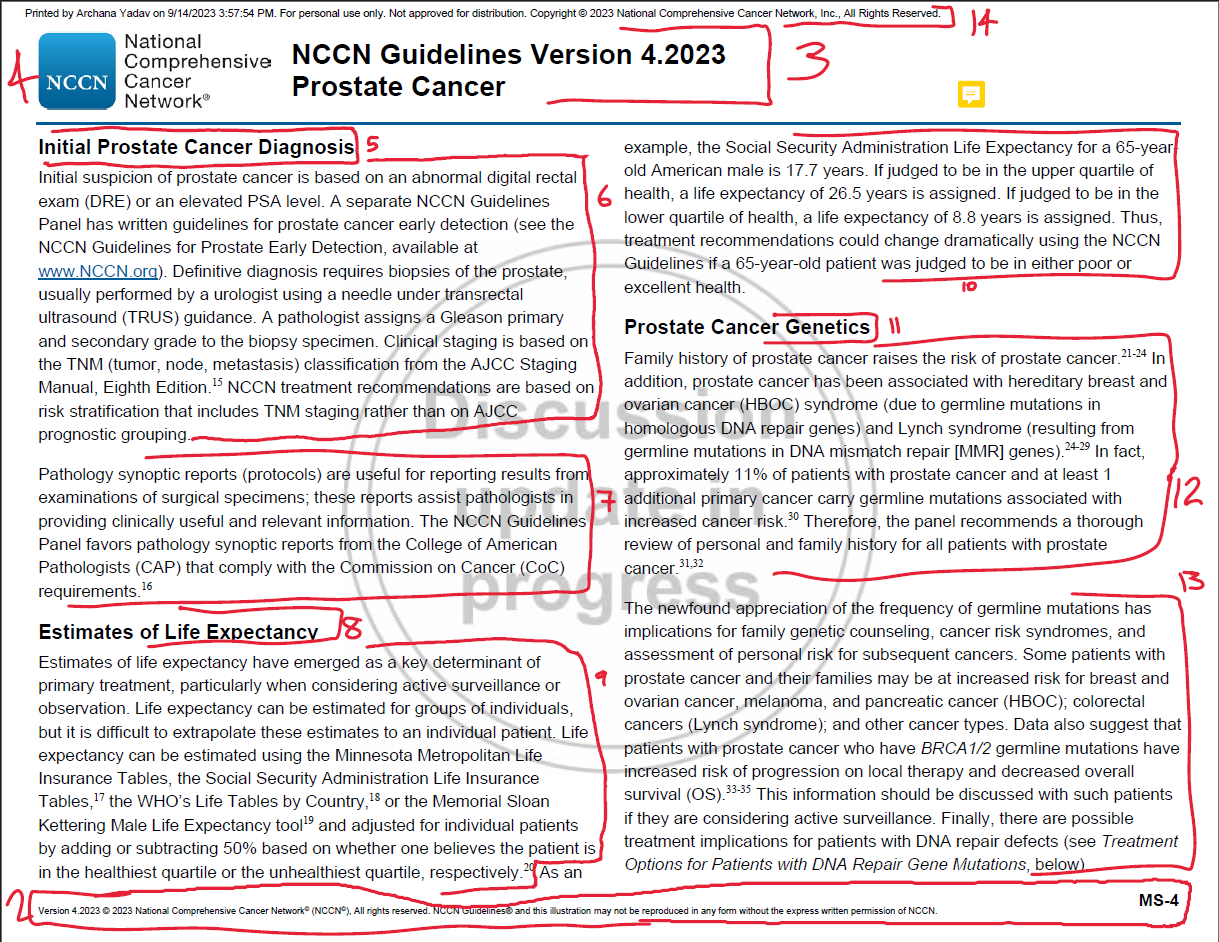

# Main Code

---



In [ ]:
! pip install pymupdf
! pip install stanza
! pip install torch
! pip install allennlp
! pip install allennlp-models
! pip install allennlp==2.1.0 allennlp-models==2.1.0
! pip install spacy
! python -m spacy download en_core_web_sm
! pip install fastcoref

In [ ]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging
import spacy
from spacy import displacy
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging
import warnings
warnings.filterwarnings("ignore")
import fitz
import spacy
import os
import stanza
import time
from stanza.server import CoreNLPClient
from fastcoref import FCoref
from fastcoref import spacy_component

In [ ]:
# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

# Function to extract paragraph contents from a PDF file
def extract_paragraph_contents(file_path):
    doc = fitz.open(file_path)  # Open the PDF document
    block_dict = {}  # Dictionary to store block information for each page
    page_num = 0

    # Iterate through all pages in the document
    for page in doc:
        page_num += 1
        file_dict = page.get_text("dict")  # Get the page dictionary
        block = file_dict["blocks"]  # Get the block information
        block_dict[page_num] = block  # Store in the block dictionary

    extracted_text = ""  # Variable to store the extracted text

    # Iterate through the block_dict to extract paragraph contents
    for page_num, block in block_dict.items():
        textval = ""
        for blocks in block:
            if blocks["type"] == 0:  # Check if the block is of type 0 (text)
                for line in blocks["lines"]:
                    for span in line["spans"]:
                        if span["size"] > 10 and span["size"] < 13 and span["font"] != 'Arial-BoldMT':
                            # Extract paragraph contents (adjust size and font condition as needed)
                            textval += span["text"]
        textval = textval.lstrip()
        extracted_text += textval

    return extracted_text

# Function to perform coreference resolution using fcoref
def coreference_resolution(text):
  extracted_text = text
  model = FCoref(device='cuda:0')
  #nlp = spacy.load("en_core_web_sm")
  nlp.add_pipe("fastcoref")
  doc = nlp(extracted_text, component_cfg={"fastcoref": {'resolve_text': True}})     # for multiple texts use nlp.pipe
  return doc._.resolved_text

# Function to tokenize sentences using spaCy
def tokenize_sentences(text):
    doc = nlp(text)
    sentences_final = [sent.text for sent in doc.sents]
    return sentences_final

# Function to extract OpenIE triples from sentences
def extract_openie_triples(sentences_final, max_sentences=5):
    corenlp_dir = './corenlp'
    stanza.install_corenlp(dir=corenlp_dir)
    os.environ["CORENLP_HOME"] = corenlp_dir

    count = 0
    triples_list = []

    with CoreNLPClient(annotators=["openie"], timeout=10000, memory='4G', endpoint="http://localhost:9001", be_quiet=True) as client:
      for sentence in sentences_final:
        count += 1
        document = client.annotate(sentence, properties={"annotators": "openie",
                                                            "outputFormat": "json", "openie.triple.strict": "true"})
        triples = []
        for sentence in document["sentences"]:
          for triple in sentence["openie"]:
            try:
              triples.append({'subject': triple['subject'], 'relation': triple['relation'], 'object': triple['object']})
            except:
              pass

        triples_list.append(triples)

        if count == max_sentences:
            break

    return triples_list

# Main function
def main():
    file_path = "/content/drive/MyDrive/PCG-subset.pdf"

    extracted_text = extract_paragraph_contents(file_path) # Extract text from pdf

    corefed_text = coreference_resolution(extracted_text) # Perform coreference resolution on extracted text

    sentences_final = tokenize_sentences(corefed_text) # Final set of TOKENIZED sentences

    triples_list = extract_openie_triples(sentences_final, max_sentences=5)

    with open("output.txt", "w", encoding="utf-8") as output_file:
        for sentence, triples in zip(sentences_final, triples_list):
          output_file.write("Sentence:\n")
          output_file.write(sentence + "\n")

          output_file.write("OpenIE Triples:\n")
          for triple in triples:
            triple_str = f"{triple}"
            output_file.write(triple_str+"\n")

          output_file.write("\n") # Add a separator between sentences

if __name__ == "__main__":
    main()

# Pymupdf parts of the code

---



In [ ]:
doc = fitz.open("/content/PCG-subset.pdf")
for page in doc:
  text = page.get_text()
  print(text)

In [ ]:
extracted_text = ""
for page_number in range(len(doc)):
  page = doc[page_number]
  page_text = page.get_text()
  extracted_text += page_text

print(extracted_text)

In [ ]:
for page in doc:
  output = page.get_text("blocks")
  print(output)
  # print(output[5]) -> for first heading
  #break

In [ ]:
for page in doc:
  output = page.get_text("dict")
  print(output)
  break

In [ ]:
block_dict = {}
page_num = 0
for page in doc: # Iterate all pages in the document
    page_num += 1 # Increase the page value by 1
    file_dict = page.get_text('dict') # Get the page dictionary
    block = file_dict['blocks'] # Get the block information
    block_dict[page_num] = block # Store in block dictionary

In [ ]:
block_dict[1] # Information of page 1

# Corenlp stanza part of the code

---



In [ ]:
# Download the Stanford CoreNLP package with Stanza's installation command
# This'll take several minutes, depending on the network speed
corenlp_dir = './corenlp'
stanza.install_corenlp(dir=corenlp_dir)

# Set the CORENLP_HOME environment variable to point to the installation location
import os
os.environ["CORENLP_HOME"] = corenlp_dir

In [ ]:
# Import client module
from stanza.server import CoreNLPClient

# Default timeout 60s
with CoreNLPClient(annotators=['openie'], timeout = 10000,
                   memory='4G', endpoint='http://localhost:9001', be_quiet=True) as client:
    text = "Prostate cancer is often associated with somatic mutations that occur in the tumor but not in the germline"
    document = client.annotate(text, properties={"annotators":"openie",
                                 "outputFormat": "json","openie.triple.strict":"true"})

In [ ]:
document["sentences"][0]["openie"]